In [1]:
import os
import sys
project_root = os.path.abspath('../src')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import wandb
key = None
if key is not None:
    wandb.login(key=key)
    os.environ['WANDB_API_KEY'] = key
os.environ["WANDB_NOTEBOOK_NAME"] = "speech_commands.ipynb"

In [2]:
!nvidia-smi

Fri May 23 07:40:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:06:00.0 Off |                    0 |
| N/A   29C    P0             41W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:


from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio import transforms as T
import os
import torch
from tqdm import tqdm
root = "data/speech_commands"
os.makedirs(root, exist_ok=True)

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, transform=None, sample_rate:int=16000,
                 n_mels:int=128, duration:float=1.0):
        super().__init__(root=root, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]
            
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.duration = duration
        self.transform = transform
        self.n_samples = int(self.duration * self.sample_rate)

        # Create label mapping
        self.labels = self._get_unique_labels()
        self.label_to_index = {label: i for i, label in enumerate(self.labels)}
        print(self.label_to_index)
        #Initialize min and max values for normalization, will be updated in findMinMax
        self.train_min = -1.0
        self.train_max = 1.0
        self.stop_transform = False

    def _get_unique_labels(self):
        labels = set()
        for filepath in self._walker:
            label = os.path.basename(os.path.dirname(filepath))
            labels.add(label)
        return sorted(list(labels))

    def __getitem__(self, n: int):
        fileid = self._walker[n]
        waveform, sample_rate, label, _,  _ = super().__getitem__(n)
        assert sample_rate == 16000
        
        # Resample if needed
        if sample_rate != self.sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Pad or trim to fixed length
        if waveform.shape[1] < self.n_samples:
            #print("Doing padding")
            # Pad
            # Pad without using torch.nn.functional by creating a new tensor
            # and copying the original waveform data into it
            # padded_waveform = torch.zeros(waveform.shape[0], self.n_samples, dtype=waveform.dtype, device=waveform.device)
            # padded_waveform[:, :waveform.shape[1]] = waveform
            # waveform = padded_waveform
            waveform = torch.nn.functional.pad(
                waveform, (0, self.n_samples - waveform.shape[1]),
                mode='constant', value=0
            )

        elif waveform.shape[1] > self.n_samples:
            # Trim
            waveform = waveform[:, :self.n_samples]
        
        #Convert to Mel spectrogram
        mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=400,
            n_mels=self.n_mels,
            hop_length=160
        )

        # mel_transform = T.Spectrogram(n_fft=400,
        #         win_length=None,
        #         hop_length=None,
        #         center=True,
        #         pad_mode="reflect",
        #         power=2.0
        #         )
        mel_spectrogram = mel_transform(waveform)
        
        # Convert to decibels
        mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)
        #mel_spectrogram_db = mel_spectrogram
        
        # Apply additional transformations if specified
        if self.transform and not self.stop_transform:
            mel_spectrogram_db = self.transform(mel_spectrogram_db)
            
        mel_spectrogram_db = (mel_spectrogram_db - self.train_min) / (self.train_max - self.train_min) - 1.0
        # Convert to 3-channel representation for compatibility with image models
        # Repeat the single channel 3 times to create RGB-like input
        assert mel_spectrogram_db.shape[0] == 1
        return mel_spectrogram_db, self.label_to_index[label]
    
    def findMinMax(self):
        self.stop_transform = True
        dataloader = torch.utils.data.DataLoader(self,
                                                 batch_size=1000,
                                                 num_workers=8,
                                                 prefetch_factor=4)
        min_val = float('inf')
        max_val = float('-inf')
        for batch in tqdm(dataloader):
            mel_spectrogram_db = batch[0].flatten()
            min_val = min(min_val, mel_spectrogram_db.min().item())
            max_val = max(max_val, mel_spectrogram_db.max().item())
        self.stop_transform = False
        return min_val, max_val
    def setMinMax(self, min_val, max_val):
        self.train_min = min_val
        self.train_max = max_val

            

In [8]:
# Import necessary transforms
import torchvision.transforms as transforms

# Define a transform to resize the mel spectrograms to 64x64
#resize_transform = transforms.Resize((64, 64))
# Import SpecAugment from torchaudio.transforms
import torchaudio.transforms as T

# Define SpecAugment transform
# SpecAugment applies time and frequency masking to the mel spectrogram
# This helps with robustness by simulating missing parts of the audio
spec_aug_transform = T.TimeMasking(time_mask_param=10)  # Mask up to 10 time steps
freq_mask = T.FrequencyMasking(freq_mask_param=5)      # Mask up to 10 frequency bins
#stretch_transform = T.TimeStretch(fixed_rate=0.5)

# Combine transforms using a compose function
# spec_aug_transform = transforms.Compose([
#     spec_aug_transform,
#     freq_mask,
#     #stretch_transform
# ])

spec_aug_transform = None


n_mels = 64


train_set = SubsetSC("training", transform=None, n_mels=n_mels)
min_val, max_val = train_set.findMinMax()
print("Training set min and max values: ", min_val, max_val)
train_set.setMinMax(min_val, max_val)
val_set = SubsetSC("validation", n_mels=n_mels)
val_set.setMinMax(min_val, max_val)
test_set = SubsetSC("testing", n_mels=n_mels)
test_set.setMinMax(min_val, max_val)

print(len(train_set), len(val_set), len(test_set))
print(len(train_set) + len(val_set) + len(test_set))


100%|██████████| 2.26G/2.26G [00:22<00:00, 110MB/s]  


{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


100%|██████████| 85/85 [01:09<00:00,  1.23it/s]


Training set min and max values:  -50.5 20.54587173461914
{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}
{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}
84843 9981 11005
105829


Sample data shape: torch.Size([1, 64, 101])
Sample label: 0


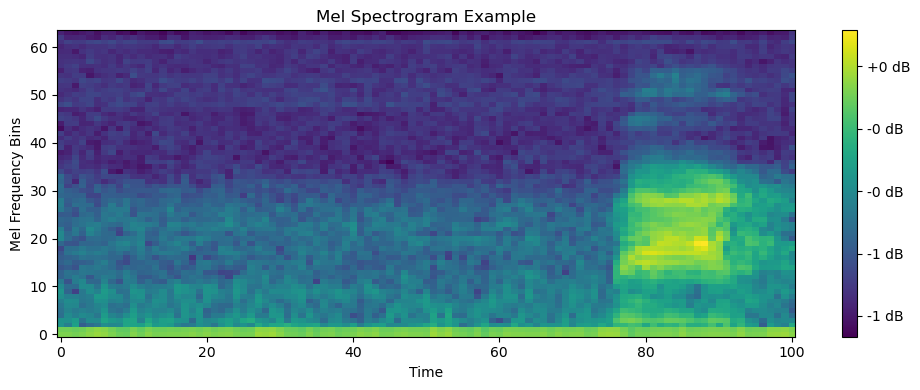

Min value: -0.8666174411773682
Max value: 0.1152271032333374
Mean value: -0.5542606711387634
Std value: 0.19549383223056793


In [9]:
# Check the input size for one image
sample_data, sample_label = train_set[0]
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample label: {sample_label}")

# Visualize the mel spectrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(sample_data[0].numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram Example')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bins')
plt.tight_layout()
plt.show()

# Print some statistics about the sample
print(f"Min value: {sample_data.min().item()}")
print(f"Max value: {sample_data.max().item()}")
print(f"Mean value: {sample_data.mean().item()}")
print(f"Std value: {sample_data.std().item()}")


In [ ]:

from run_experiment import run_expriment
import random
import string


# activation = 'relu'
# enable_boundary_loss = False
# disable_batchnorm_grad_clip_exclusion = True
# lambda_penalty = -1
#learnable_coeffs = False
# gradient_clip_val = None


activation = 'poly'
enable_boundary_loss = True #Whether to enable boundary loss
disable_batchnorm_grad_clip_exclusion = False #Whether to disable batchnorm grad clip exclusion
lambda_penalty = 100 #Penalty for boundary loss
gradient_clip_val = 1.0 #Gradient clip value
learnable_coeffs = True #Whether to learnable coefficients


project_name = "test"
num_classes = 35
max_epoch = 20
data_workers = 8
model = "resnet18"
dataset = {"train": train_set, "val": val_set, "test": test_set}

run_id = "test"
custom_tag = "test"

ori_activaiton = "relu"
samp_size = 100
pol_degree = 8

dropout = 0.0
learning_rate = 0.001

pol_degree_map = {
    2:{"B": 25, "penalty_B": 25},
    4:{"B": 40, "penalty_B": 40 * 0.75},
    8:{"B": 70, "penalty_B": 70 * 1.0},
}

B = pol_degree_map[pol_degree]["B"]
penalty_B = pol_degree_map[pol_degree]["penalty_B"]
boundary_loss_params = {'type': 'exp', 'penalty_B':  penalty_B, 'acc_norm': 'sum'}

input_size = (1, 64, 101)

optimizer_params = {
        'type': 'adamw',
        'lr': learning_rate,
        'params': {
        }
}
scheduler_params = {'type': 'reduce_on_plateau',
                        'params': {
                                'mode': 'min',
                                'factor': 0.1,
                                'patience': 5,
                                'threshold': 0.1,
                                'verbose': True
                        },
                        'monitor': 'val_acc_epoch'
}

actvation_params =  {
        "ori_activation": ori_activaiton,
        'B': B,
        'samp_size': samp_size,
        'pol_degree': pol_degree,
        'learnable_coeffs': learnable_coeffs,
        'initialization': "least_square",
        'boundary_loss_params': boundary_loss_params

    }
model_params = {
    "use_singleton_activation": False,
    "bn_before_act": False,
    "activation": activation,
    "dropout": dropout,
    "num_classes":num_classes,
    "actvation_params": actvation_params,
    "model":model,
    "input_size": input_size
}

training_params = {
    "enable_boundary_loss":enable_boundary_loss,
    "gradient_clip_val": gradient_clip_val,
    "max_epoch": max_epoch,
    "lambda_penalty": lambda_penalty,
    "disable_batchnorm_grad_clip_exclusion": disable_batchnorm_grad_clip_exclusion,
    'optimizer_params': optimizer_params,
    'scheduler_params': scheduler_params

}

dataset_params = {
    "data_workers": data_workers,
    "dataset": dataset,
    "batch_size": 50
}

project_params = {"run_id": run_id,
                  "project_name": project_name,
                  "custom_tag": custom_tag
                  }

run_expriment(project_params=project_params, dataset_params=dataset_params,
               model_params=model_params, training_params=training_params)


#
#       \
